In [173]:
import pandas as pd
import numpy as np
import torch
import seaborn as sb
from torch.utils.data import Dataset, DataLoader
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.base import BaseEstimator
from tqdm import tqdm
from math import ceil


DATA_PATH = "../data/cross_entropy_loss_dataset"
pd.set_option('display.max_columns', None)

In [4]:
raw_parts_features_dataset = pd.read_csv(DATA_PATH+"/prepared_parts_dataset.csv", index_col='transformed_mpn')
alternates_dataset = pd.read_csv(DATA_PATH+"/pairs_dataset_50.csv")
alternates_dataset = alternates_dataset.sample(frac=1)

In [5]:
NUMERICAL_FEATURES = [
    'FullCounterfeitData|CounterfeitOverallRisk',
    'FullCounterfeitData|ManCounterfeitReportsCount',
    'FullCounterfeitData|PlCounterfeitReportsCount',
    'FullCounterfeitData|TimeSinceMarketIntroduction',
    'LifeCycleData|EstimatedYearsToEOL',
    'LifeCycleData|MaximumEstimatedYearsToEOL',
    'LifeCycleData|MinimumEstimatedYearsToEOL',
    'LifeCycleData|OverallRisk',
    'PackageData|Feature>Product Depth:Value',
    'ParametricData|Features>Maximum Operating Temperature:Value',
    'ParametricData|Features>Minimum Operating Temperature:Value',
    'ParametricData|Features>Number of Terminals:Value',
    'ParametricData|Features>Product Height:Value',
    'ParametricData|Features>Product Length:Value',
    'ParametricData|Features>Tolerance:Value',
    'RiskData|NumberOfDistributors',
    'RiskData|NumberOfOtherSources'
]

CATEGORICAL_FEATURES = [
    'EnvironmentalDto|ChinaRoHS|EPUP',
    'EnvironmentalDto|ChinaRoHS|PBDEFlag',
    'EnvironmentalDto|ChinaRoHS|SourceType',
    'EnvironmentalDto|ConflictMineralStatus',
    'EnvironmentalDto|EICCMembership',
    'EnvironmentalDto|EICCTemplateVersion',
    'EnvironmentalDto|Exemption',
    'EnvironmentalDto|ExemptionCodes',
    'EnvironmentalDto|HalgonFree',
    'EnvironmentalDto|RareEarthElementInformation',
    'EnvironmentalDto|RoHSVersion',
    'EnvironmentalDto|RohsIdentifier',
    'EnvironmentalDto|SourceType',
    'FullCounterfeitData|HistoricalShortagesInventoryReported',
    'FullCounterfeitData|IsPopularPart',
    'LifeCycleData|LifeCycleRiskGrade',
    'LifeCycleData|PartLifecycleCode',
    'PackageData|Feature>Mounting:Value',
    'PackageData|Feature>Package/Case:Value',
    'ParametricData|Features>Life Cycle:Value',
    'ParametricData|Features>Mounting:Value',
    'ParametricData|Features>Packaging:Value',
    'ParametricData|Features>ROHS:Value',
    'ParametricData|Features>Technology:Value',
    'ParametricData|Features>Temperature Grade:Value',
    'ParametricData|Features>Termination Style:Value',
    'ReachData|ReachDto|CASNumber',
    'ReachData|ReachDto|ContainsSVHC',
    'ReachData|ReachDto|EchaNotification',
    'ReachData|ReachDto|ReachStatus',
    'ReachData|ReachDto|SourceType',
    'RiskData|CrossesPartCategory',
    'RiskData|InventoryRisk',
    'RiskData|LifecycleRisk',
    'RiskData|MultiSourcingRisk',
    'RiskData|RohsRisk',
    'SummaryData|AECQualified',
    'SummaryData|Automotive',
    'SummaryData|DoseLevel',
    'SummaryData|ECCN',
    'SummaryData|ESDClass',
    'SummaryData|PartMarking',
    'SummaryData|RadHard',
    'SummaryData|RoHSVersion',
    'SummaryData|UNSPSC',
    'SummaryData|USChinaTariffImpact'
]

TEXTUAL_FEATURES = ['SummaryData|PLName', 'SummaryData|PartDescription']

DATE_FEATURES = [
    'EnvironmentalDto|ExemptionExpirationDate',
    'LifeCycleData|LTBDate',
    'ReachData|ReachDto|SVHCDateOfInclusion',
    'ReachData|ReachDto|SVHCListVersion',
    'SummaryData|IntroductionDate',
    'SummaryData|LastCheckDate'
]

## Data preparation

In [6]:
parts_features = raw_parts_features_dataset.copy()

# Numerical Features imputation
imputer = KNNImputer(n_neighbors=5, weights='distance')
parts_features[NUMERICAL_FEATURES] = imputer.fit_transform(parts_features[NUMERICAL_FEATURES])

## Here starts the pipeline

In [7]:
parts_features = parts_features[CATEGORICAL_FEATURES+NUMERICAL_FEATURES]

In [8]:
ordinal_encoders = OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1)
numerical_standard_scalers = StandardScaler()

ordinal_encoders.fit(X=parts_features[CATEGORICAL_FEATURES])
numerical_standard_scalers.fit(X=parts_features[NUMERICAL_FEATURES])

StandardScaler()

In [58]:
class PartsDataset(Dataset):
    def __init__(self, parts_features: pd.DataFrame, alternates: pd.DataFrame, num_features: list, cat_features: list, text_features: list, date_features: list) -> None:
        super(PartsDataset, self).__init__()
        self.parts_features = parts_features.copy()
        self.alternates = alternates.copy()
        self.alternates.reset_index(inplace=True, drop=True)

        self.num_features = num_features
        self.cat_features = cat_features
        self.text_features = text_features
        self.date_features = date_features
    
    def __len__(self):
        return len(self.alternates)
    
    def __getitem__(self, index):
        p1_num_data = numerical_standard_scalers.transform(self.parts_features.loc[self.alternates['original_mpn'][[index]], self.num_features])[0].astype(np.float64)
        p1_cat_data = ordinal_encoders.transform(self.parts_features.loc[self.alternates['original_mpn'][[index]], self.cat_features])[0].astype(np.int64)

        p2_num_data = numerical_standard_scalers.transform(self.parts_features.loc[self.alternates['alternate_mpn'][[index]], self.num_features])[0].astype(np.float64)
        p2_cat_data = ordinal_encoders.transform(self.parts_features.loc[self.alternates['alternate_mpn'][[index]], self.cat_features])[0].astype(np.int64)

        target_similarity = self.alternates['similarity'][index].astype(np.float64)

        return p1_num_data, p1_cat_data, p2_num_data, p2_cat_data, target_similarity


In [65]:
class PartEncoder(torch.nn.Module):
    def __init__(self, cat_emb_dims: list, final_part_emb_dim: int):
        super(PartEncoder, self).__init__()
        self.cat_emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y) for x, y in cat_emb_dims])
        self.fc1 = torch.nn.Linear(in_features=len(NUMERICAL_FEATURES)+sum([y for x, y in cat_emb_dims]), out_features=100)
        self.batch_norm1 = torch.nn.BatchNorm1d(100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=50)
        self.droup_out = torch.nn.Dropout(p=0.2)
        self.fc3 = torch.nn.Linear(in_features=50, out_features=final_part_emb_dim)
        self.double()

    def forward(self, input_num_data, input_cat_data):
        x = [emb_layer(input_cat_data[:, i]) for i, emb_layer in enumerate(self.cat_emb_layers)]
        x = torch.cat(x, 1)
        x = torch.cat([x, input_num_data], 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.droup_out(x)
        x = self.fc3(x)
        return x

In [66]:
class SimilarityPredictor(torch.nn.Module):
    def __init__(self, cat_emb_dims: list, final_part_emb_dim: int):
        super(SimilarityPredictor, self).__init__()
        self.part_encoder = PartEncoder(cat_emb_dims, final_part_emb_dim)
        
        self.batch_nom1 = torch.nn.BatchNorm1d(2*final_part_emb_dim)
        self.fc1 = torch.nn.Linear(in_features=2*final_part_emb_dim, out_features=20)
        self.drop_out1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(in_features=20, out_features=10)
        self.fc3 = torch.nn.Linear(in_features=10, out_features=1)
        self.double()
    
    def forward(self, p1_num_data, p1_cat_data, p2_num_data, p2_cat_data):
        p1_encoded = self.part_encoder(p1_num_data, p1_cat_data)
        p2_encoded = self.part_encoder(p2_num_data, p2_cat_data)

        x = torch.cat([p1_encoded, p2_encoded], 1)
        x = self.batch_nom1(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.drop_out1(x)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

In [83]:
cat_features_emb_dimensions = parts_features[CATEGORICAL_FEATURES].describe().loc['unique'].apply(lambda x: (x, min(50, ceil(1.6*x**0.56)))).values
final_part_emb_dimension = ceil(1.6*parts_features.shape[1]**0.56)

In [104]:
BATCH_SIZE = 150
train_alternates_dataset, test_alternates_dataset = train_test_split(alternates_dataset, test_size=0.2, shuffle=True, stratify=alternates_dataset['similarity'])
train_dataset = PartsDataset(parts_features, train_alternates_dataset, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TEXTUAL_FEATURES, DATE_FEATURES)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10)

In [105]:
similarity_predictor = SimilarityPredictor(cat_features_emb_dimensions, final_part_emb_dimension)
optimizer = torch.optim.SGD(similarity_predictor.parameters(), lr=0.1, momentum=0.9)
criterion = torch.nn.BCELoss()

In [ ]:
EPOCHS = 12
similarity_predictor.train()
epoches_losses = []
for epoch in range(EPOCHS):
    print(" ================================== EPOCH {} ================================== ".format(epoch))
    epoch_loss = 0
    for p1_num_data, p1_cat_data, p2_num_data, p2_cat_data, target_similarity in tqdm(train_data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        
        output = similarity_predictor(p1_num_data, p1_cat_data, p2_num_data, p2_cat_data).squeeze()
        loss = criterion(output, target_similarity)
        loss.backward()
        optimizer.step()
        
        epoch_loss = epoch_loss + len(target_similarity) * loss.detach().numpy()
    
    epoches_losses.append(epoch_loss/len(train_dataset))

<AxesSubplot: >

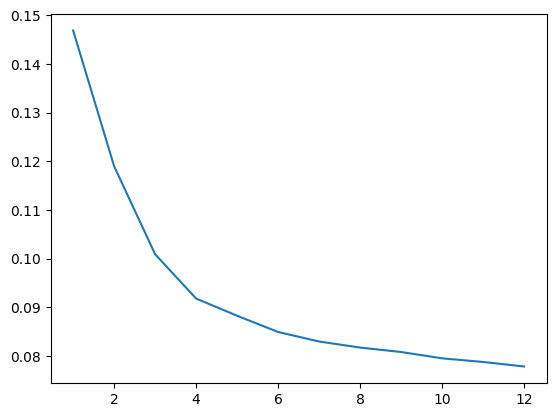

In [113]:
sb.lineplot(x=range(1, len(epoches_losses)+1), y=epoches_losses)

In [114]:
test_dataset = PartsDataset(parts_features, test_alternates_dataset, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TEXTUAL_FEATURES, DATE_FEATURES)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=10)

In [125]:
similarity_predictor.eval()
test_loss = 0
result_df = pd.DataFrame(columns=['target', 'pred'])
for p1_num_data, p1_cat_data, p2_num_data, p2_cat_data, target_similarity in tqdm(test_data_loader, desc="Test", leave=False):
    with torch.no_grad():
        output = similarity_predictor(p1_num_data, p1_cat_data, p2_num_data, p2_cat_data).squeeze()
        pred = torch.where(output > 0.5, 1, 0)
        result_df = pd.concat([result_df, pd.DataFrame({'target': target_similarity.detach().numpy(), 'pred': pred.detach().numpy()})])
        loss = criterion(output, target_similarity)
        
        test_loss = test_loss + len(target_similarity) * loss.detach().numpy()


In [169]:
result_df = result_df.astype(np.int64)
test_loss = test_loss/len(test_dataset)

confusion_matrix = metrics.confusion_matrix(y_true=result_df['target'], y_pred=result_df['pred'])

In [172]:
print(test_loss)

0.06842558481844327


In [134]:
print(metrics.classification_report(y_true=result_df['target'], y_pred=result_df['pred']))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    144910
           1       0.68      0.88      0.76      9114

    accuracy                           0.97    154024
   macro avg       0.83      0.92      0.87    154024
weighted avg       0.97      0.97      0.97    154024



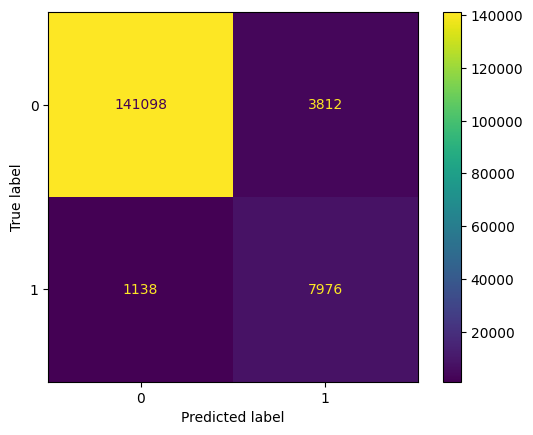

In [136]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()

In [212]:
import pickle

def export_object(object, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(object, f)

def import_object(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

class CustomColumnsTransformer():
    def __init__(self, num_data_transformer: BaseEstimator, cat_data_transformer: BaseEstimator, num_features: list, cat_features: list):
        self._num_data_transformer = num_data_transformer
        self._cat_data_transformer = cat_data_transformer
        self._num_features = num_features
        self._cat_features = cat_features
    
    def input_features(self):
        return self._num_features, self._cat_features

    def transform(self, X: pd.DataFrame):
        num_data = self._num_data_transformer.transform(X[self._num_features])
        cat_data = self._cat_data_transformer.transform(X[self._cat_features])
        return num_data, cat_data


class PartEncoderFinal():
    def __init__(self, columns_transformer: CustomColumnsTransformer, part_encoder: PartEncoder):
        self.columns_transformer = columns_transformer
        self._part_encoder = part_encoder.eval()

    def encode_parts(self, X: pd.DataFrame):
        num_data, cat_data = self.columns_transformer.transform(X)
        num_data = torch.Tensor(num_data).type(torch.float64)
        cat_data = torch.Tensor(cat_data).type(torch.int64)
        encoded_parts = None
        with torch.no_grad():
            encoded_parts = self._part_encoder(num_data, cat_data).numpy()
        return encoded_parts
    
    def export(self, transformer_file_name, encoder_file_name):
        export_object(self.columns_transformer, transformer_file_name)
        export_object(self._part_encoder, encoder_file_name)
    
    @staticmethod
    def import_encoder(transformer_file_name, encoder_file_name):
        columns_transformer = import_object(transformer_file_name)
        part_encoder = import_object(encoder_file_name)
        return PartEncoderFinal(columns_transformer, part_encoder)

In [213]:
custom_columns_transformer = CustomColumnsTransformer(numerical_standard_scalers, ordinal_encoders, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)
part_encoder_final = PartEncoderFinal(custom_columns_transformer, similarity_predictor.part_encoder)

In [216]:
part_encoder_final.export('../models/1_custom_columns_transformer.pickle', '../models/1_part_encoder_final.pickle')

In [227]:
part_encoder_final.encode_parts(parts_features)

array([[-24.99752317, -52.98928089, -48.71926678, ..., -20.84791448,
         53.69913685,  17.43607968],
       [  5.77832998,  10.99185738,  38.98347536, ...,   6.02075078,
        -37.89697606,   4.28543253],
       [-10.76916994, -41.54472749,  -8.10065523, ...,   2.82907285,
         56.45584288,   8.2069462 ],
       ...,
       [ 40.74688253, -27.67287858,  50.32689007, ...,  24.81188801,
        -50.6402413 , -21.18058608],
       [-25.56798951, -40.55741424, -34.28883237, ...,  -7.27551878,
         54.15463044,  13.35296295],
       [-12.57079739, -30.01596048, -22.45847194, ..., -16.30267106,
         32.05649955,   2.35323221]])